In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn.functional as F
import torch

In [ ]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

In [ ]:
dataset_train = ImageFolder(
    "/content/drive/MyDrive/Scrapping/clouds_train",
    transform = train_transforms,


)

In [ ]:
from torch.utils.data import DataLoader
dataloader_train = DataLoader(
    dataset_train,
    shuffle = True,
    batch_size = 1
)

In [ ]:
image, label = next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 3, 64, 64])


In [ ]:
F.one_hot(label,7)

tensor([[1, 0, 0, 0, 0, 0, 0]])

In [ ]:
image = image.squeeze().permute(1,2,0)
print(image.shape)

torch.Size([64, 64, 3])


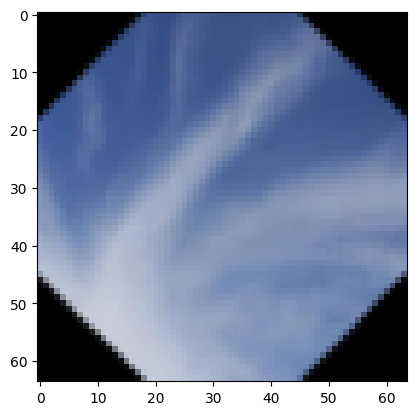

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.show()

## Convolutional Neural Networks

In [ ]:
import torch.nn as nn
class Net(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size = 5, padding = 1),
        nn.ELU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Conv2d(16, 32, kernel_size = 5, padding = 1),
        nn.ELU(),
        nn.MaxPool2d(kernel_size = 2),
        nn.Flatten()
    )


    self.classifier = nn.Sequential(
        nn.Linear(32 *14 * 14, 7),
        nn.Softmax()
    )
  def forward(self, x):
    x = self.feature_extractor(x)

    x = x.view(-1, 32 * 14 * 14)
    
    x = self.classifier(x)
    return x

In [69]:
import torch.optim as optim
net = Net(num_classes = 7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
num_epochs = 10
for epoch in range(num_epochs):

    running_loss = 0.0
    for features, labels in dataloader_train:
     
      optimizer.zero_grad()

      output = net(features.float())
      labels = F.one_hot(labels,7)

      
      loss = criterion(output, labels.to(torch.float32))

      

      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")



Epoch 1, Loss: 2.0654
Epoch 2, Loss: 2.0620
Epoch 3, Loss: 2.0620
Epoch 4, Loss: 2.0620
Epoch 5, Loss: 2.0620
Epoch 6, Loss: 2.0620
Epoch 7, Loss: 2.0620
Epoch 8, Loss: 2.0620
Epoch 9, Loss: 2.0632
Epoch 10, Loss: 2.0620


In [ ]:
30*30*64

57600

In [ ]:
print(f"Output batch size: {output.dtype}")
print(f"Labels batch size: {labels.dtype}")
print(features.shape)

Output batch size: torch.float32
Labels batch size: torch.int64
torch.Size([1, 3, 64, 64])


## Model Evaluation

**micro** micro average is best when our class is imbalance.
**macro** care on performance on small dataset.

In [85]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64)),
])

In [74]:
dataset_test = ImageFolder(
    "/content/drive/MyDrive/Scrapping/clouds_test",
    transform = test_transforms,


)

In [87]:
dataloader_test = DataLoader(
    dataset_test,
    shuffle = True

)

In [88]:
from torchmetrics import Recall
recall_per_class = Recall(task = "multiclass",num_classes = 7, average = None)
recall_micro = Recall(task = "multiclass", num_classes = 7, average = "micro")
recall_macro = Recall(task = "multiclass", num_classes = 7, average = "macro")
recall_weighted = Recall(task = "multiclass", num_classes = 7, average = "weighted")
net.eval()
with torch.no_grad():
    for features, labels in dataloader_test:
        
        outputs = net(features)
        _,preds = torch.max(output, 1)
        recall_micro(preds, labels)
recall = recall_micro.compute()
print(recall)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor(0.0823)


In [92]:
from torchmetrics import Precision

metric_precision = Precision(task = "multiclass", num_classes = 7, average = None)
metric_recall = Recall(task = "multiclass", num_classes = 7, average = None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Precision: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0823, 0.0000])
Recall: tensor([0., 0., 0., 0., 0., 1., 0.])


In [93]:

metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.011757790111005306
Recall: 0.1428571492433548


In [90]:
dataset_test.class_to_idx

{'cirriform clouds': 0,
 'clear sky': 1,
 'cumulonimbus clouds': 2,
 'cumulus clouds': 3,
 'high cumuliform clouds': 4,
 'stratiform clouds': 5,
 'stratocumulus clouds': 6}

In [91]:
{k:recall[v].item() for k , v in dataset_test.class_to_idx.items()}

{'cirriform clouds': 0.0,
 'clear sky': 0.0,
 'cumulonimbus clouds': 0.0,
 'cumulus clouds': 0.0,
 'high cumuliform clouds': 0.0,
 'stratiform clouds': 1.0,
 'stratocumulus clouds': 0.0}